# **Final Project for CS6120: Natural Language Processing** 

### **Detecting Hate Speech in Tweets using the Ethos Dataset and DistilBERT Transformers Language Model**

### **Debra Cooperman**


### Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import ktrain
from ktrain import text
import numpy as np
import warnings
warnings.filterwarnings('ignore')

### Data preparation: ETHOS Dataset

In [2]:
# create ethos dataframe
ethos_df = pd.read_csv("Ethos_Dataset_Binary.txt", sep=';') 

In [3]:
print(ethos_df.head())
print(len(ethos_df))

                                             comment  isHate
0          You should know women's sports are a joke     1.0
1    You look like Sloth with deeper Down’s syndrome     1.0
2  You look like Russian and speak like Indian. B...     1.0
3               Women deserve to be abused, I guess.     1.0
4  Women are made for making babies and cooking d...     1.0
998


In [4]:
# establish threshold from overall "isHate" score
ethos_df.loc[ethos_df["isHate"] >= .5, "isHate"] = 1
ethos_df.loc[ethos_df["isHate"] < .5, "isHate"] = 0

In [5]:
# Train test spit, use stratify to balance the classes
X_train, X_val, y_train, y_val = train_test_split(ethos_df["comment"], 
                                                  ethos_df["isHate"],
                                                  test_size = 0.15,
                                                  random_state = 17,
                                                  stratify = ethos_df["isHate"])

### Train DistilBERT model 

In [6]:
# "uncased means case insenstive"
MODEL_NAME = 'distilbert-base-uncased'

In [7]:
is_hate_vals = ethos_df.isHate.unique()
dbert = text.Transformer(MODEL_NAME, maxlen=500, class_names=is_hate_vals)

In [8]:
# preprocess to create word embeddings 
train = dbert.preprocess_train(X_train.to_list(), y_train.to_list())
val = dbert.preprocess_test(X_val.to_list(), y_val.to_list())

preprocessing train...
language: en
train sequence lengths:
	mean : 20
	95percentile : 53
	99percentile : 120


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 23
	95percentile : 66
	99percentile : 107


In [9]:
# create model after preprocessing
model = dbert.get_classifier()
learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size=6)

simulating training for different learning rates... this may take a few moments...
Epoch 1/2
141/141 [==============================] - 580s 4s/step - loss: 0.6891 - accuracy: 0.5213
Epoch 2/2
141/141 [==============================] - 376s 3s/step - loss: 80.9444 - accuracy: 0.5289


done.
Visually inspect loss plot and select learning rate associated with falling loss


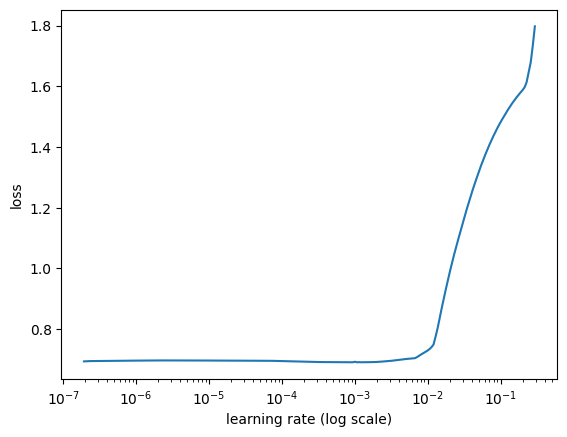

In [10]:
# simulate training to find optimal learning rate
learner.lr_find(show_plot=True, max_epochs=2)

In [11]:
learner.fit_onecycle(5e-6, 6)



begin training using onecycle policy with max lr of 5e-06...
Epoch 1/6
142/142 [==============================] - 610s 4s/step - loss: 0.6934 - accuracy: 0.5059 - val_loss: 0.6895 - val_accuracy: 0.5600
Epoch 2/6
142/142 [==============================] - 603s 4s/step - loss: 0.6806 - accuracy: 0.5601 - val_loss: 0.6691 - val_accuracy: 0.5667
Epoch 3/6
142/142 [==============================] - 603s 4s/step - loss: 0.6272 - accuracy: 0.6557 - val_loss: 0.5566 - val_accuracy: 0.7400
Epoch 4/6
142/142 [==============================] - 604s 4s/step - loss: 0.4533 - accuracy: 0.8090 - val_loss: 0.4759 - val_accuracy: 0.7867
Epoch 5/6
142/142 [==============================] - 604s 4s/step - loss: 0.2869 - accuracy: 0.9127 - val_loss: 0.4739 - val_accuracy: 0.7867
Epoch 6/6
142/142 [==============================] - 605s 4s/step - loss: 0.2161 - accuracy: 0.9446 - val_loss: 0.4700 - val_accuracy: 0.7933


In [12]:
learner.validate(val_data=val)

5/5 [==============================] - 32s 6s/step
              precision    recall  f1-score   support

           0       0.83      0.80      0.81        85
           1       0.75      0.78      0.77        65

    accuracy                           0.79       150
   macro avg       0.79      0.79      0.79       150
weighted avg       0.79      0.79      0.79       150



array([[68, 17],
       [14, 51]])

In [13]:
# confusion matrix based on above output
cf_matrix = np.array([[68, 17], [14, 51]])

<AxesSubplot: >

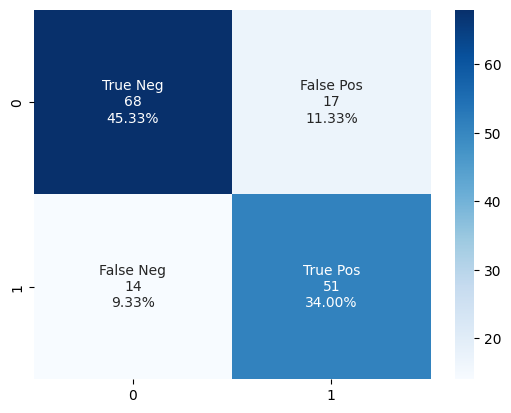

In [14]:
# create sns confusion matrix visualization
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

### View the top 5 missed predictions for ETHOS test set (where the loss was highest)

In [15]:
learner.view_top_losses(n=5, preproc=dbert)

5/5 [==============================] - 30s 6s/step
----------
id:60 | loss:3.05 | true:0.0 | pred:1.0)

----------
id:31 | loss:3.02 | true:0.0 | pred:1.0)

----------
id:40 | loss:2.94 | true:0.0 | pred:1.0)

----------
id:34 | loss:2.58 | true:0.0 | pred:1.0)

----------
id:6 | loss:2.48 | true:1.0 | pred:0.0)



In [16]:
predictor = ktrain.get_predictor(learner.model, preproc=dbert)

### False positive example

In [17]:
print(X_val.iloc[60])

I wouldn’t like this girl as a police officer. I want police to keep me safe, she and every other woman cannot keep us safe they are week


### False negative example

In [18]:
print(X_val.iloc[6])

Deport the fucking brainless worthless pieces of shit freeloaders after they are all shot


## Data Preparation: Twitter Sentiment Analysis Dataset

In [21]:
kaggle_df = pd.read_csv("kaggle_twitter.csv") 

In [22]:
kaggle_df.head()
print(len(kaggle_df))

31962


In [23]:
kaggle_test = dbert.preprocess_test(kaggle_df["tweet"].to_list(), kaggle_df["label"].to_list())

preprocessing test...
language: en
test sequence lengths:
	mean : 13
	95percentile : 23
	99percentile : 26


## Hate speech prediction: Twitter Sentiment Analysis Dataset

In [24]:
learner.validate(val_data=kaggle_test)

31962/31962 [==============================] - 2952s 92ms/step
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     29720
           1       0.44      0.25      0.32      2242

    accuracy                           0.93     31962
   macro avg       0.69      0.61      0.64     31962
weighted avg       0.91      0.93      0.92     31962



array([[29021,   699],
       [ 1691,   551]])

## Data Preparation: Hate Speech and Offensive Language Dataset

In [25]:
# https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset
# kaggle dataset one
kaggle_one_df = pd.read_csv("labeled_data.csv") 

In [26]:
kaggle_one_df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [27]:
print(len(kaggle_one_df))

24783


In [28]:
kaggle_one_df.loc[kaggle_one_df["class"] == 2, "class"] = "not hate"
kaggle_one_df.loc[kaggle_one_df["class"] == 1, "class"] = "not hate"
kaggle_one_df.loc[kaggle_one_df["class"] == 0, "class"] = "hate"
kaggle_one_df.loc[kaggle_one_df["class"] == "not hate", "class"] = 0
kaggle_one_df.loc[kaggle_one_df["class"] == "hate", "class"] = 1

In [29]:
kaggle_one_df = kaggle_one_df[["tweet", "class"]]
kaggle_one_df.head()

,tweet,class
0,!!! RT @mayasolovely: As a woman you shouldn't...,0
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,0
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,0
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,0
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,0


In [31]:
kaggle_one_test = dbert.preprocess_test(kaggle_one_df["tweet"].to_list(), kaggle_one_df["class"].to_list())

preprocessing test...
language: en
test sequence lengths:
	mean : 14
	95percentile : 26
	99percentile : 29


## Hate speech prediction: Hate Speech and Offensive Language Dataset

In [32]:
learner.validate(val_data=kaggle_one_test)

24783/24783 [==============================] - 21439s 865ms/step
              precision    recall  f1-score   support

           0       0.96      0.82      0.88     23353
           1       0.11      0.38      0.17      1430

    accuracy                           0.79     24783
   macro avg       0.53      0.60      0.53     24783
weighted avg       0.91      0.79      0.84     24783



array([[19080,  4273],
       [  891,   539]])